## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [27]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses

import os,random
import tensorflow as tf

# Optional: set environment variable
os.environ["KERAS_BACKEND"] = "tensorflow"

# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled for GPU.")
    except RuntimeError as e:
        print(" Could not set memory growth:", e)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Devices:", tf.config.list_physical_devices())

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Reshape, Dense, Dropout, Activation, Flatten,
    GaussianNoise, Conv2D, MaxPooling2D, ZeroPadding2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import pickle, random, sys
import numpy as np
from tensorflow.keras import backend as K


 Memory growth enabled for GPU.
TensorFlow version: 2.10.1
Num GPUs Available: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Dataset setup

In [ ]:
# Load the dataset
with open("RML2016.10a_dict.dat", "rb") as f:
    Xd = pickle.load(f, encoding='latin1')  # Required if the file was pickled in Python 2

# Get all modulation types and SNRs
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])

X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod, snr)])
        lbl.extend([(mod, snr)] * Xd[(mod, snr)].shape[0])

X = np.vstack(X)

In [ ]:


np.random.seed(2016)

n_examples = X.shape[0]
n_train = int(n_examples * 0.5)

# Shuffle indices
train_idx = np.random.choice(range(n_examples), size=n_train, replace=False)
test_idx = np.array(list(set(range(n_examples)) - set(train_idx)))

# Get train/test splits
X_train = X[train_idx]
X_test = X[test_idx]

# One-hot encoding helper
def to_onehot(yy):
    yy = list(yy)  # Ensure it's a list
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1

# Labels as integer class indices
Y_train = to_onehot([mods.index(lbl[i][0]) for i in train_idx])
Y_test = to_onehot([mods.index(lbl[i][0]) for i in test_idx])


In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)

classes = mods

In [10]:

# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization


# Hyperparameters
K.set_image_data_format('channels_first')

# %%
dr = 0.5                       # Dropout rate

# %%
#Model Definition
model = Sequential()

# Input reshaping
model.add(Reshape([1] + in_shp, input_shape=in_shp))

# Conv Layer 1
model.add(ZeroPadding2D(padding=(0, 2), data_format='channels_first'))
model.add(Conv2D(
    filters=256,
    kernel_size=(1, 3),
    padding='valid',
    activation='relu',
    kernel_initializer='glorot_uniform',
    name='conv1',
    data_format='channels_first'
))
model.add(Dropout(dr))

# Conv Layer 2
model.add(ZeroPadding2D(padding=(0, 2), data_format='channels_first'))
model.add(Conv2D(
    filters=80,
    kernel_size=(2, 3),
    padding='valid',
    activation='relu',
    kernel_initializer='glorot_uniform',
    name='conv2',
    data_format='channels_first'
))
model.add(Dropout(dr))

# Dense Layers
model.add(Flatten())
model.add(Dense(
    256,
    activation='relu',
    kernel_initializer='he_normal',
    name='dense1'
))
model.add(Dropout(dr))
model.add(Dense(
    len(classes),
    kernel_initializer='he_normal',
    name='dense2'
))
model.add(Activation('softmax'))

# Optional reshape to match output expectations
model.add(Reshape([len(classes)]))

# %%
# Compile Model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# %%
# Model Summary (clean display)
print("\n Model Summary:")
# model.summary();
from IPython.display import display, Markdown

def pretty_model_summary(model):
    lines = []
    model.summary(print_fn=lambda x: lines.append(x))
    display(Markdown("```\n" + "\n".join(lines) + "\n```"))

pretty_model_summary(model)


 Model Summary:


```
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 reshape_4 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 1, 2, 132)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 256, 2, 130)       1024      
                                                                 
 dropout_6 (Dropout)         (None, 256, 2, 130)       0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 256, 2, 134)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 80, 1, 132)        122960    
                                                                 
 dropout_7 (Dropout)         (None, 80, 1, 132)        0         
                                                                 
 flatten_2 (Flatten)         (None, 10560)             0         
                                                                 
 dense1 (Dense)              (None, 256)               2703616   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense2 (Dense)              (None, 11)                2827      
                                                                 
 activation_2 (Activation)   (None, 11)                0         
                                                                 
 reshape_5 (Reshape)         (None, 11)                0         
                                                                 
=================================================================
Total params: 2,830,427
Trainable params: 2,830,427
Non-trainable params: 0
_________________________________________________________________
```

# Build the NN Model

In [11]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [12]:
#  Set batch size and epochs
batch_size = 256  # ↓ reduced from 1024 to avoid OOM
epochs = 50
filepath = 'convmodrecnets_CNN2_0.5.weights.h5'

# Modernized training loop
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks=[
        ModelCheckpoint(
            filepath,
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            save_weights_only=True,
            mode='auto'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
)

# Load the best weights after training
model.load_weights(filepath)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.80661, saving model to convmodrecnets_CNN2_0.5.weights.h5
430/430 - 27s - loss: 2.1152 - accuracy: 0.2182 - val_loss: 1.8066 - val_accuracy: 0.3355 - 27s/epoch - 62ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.80661 to 1.62816, saving model to convmodrecnets_CNN2_0.5.weights.h5
430/430 - 22s - loss: 1.7508 - accuracy: 0.3466 - val_loss: 1.6282 - val_accuracy: 0.3909 - 22s/epoch - 52ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.62816 to 1.51793, saving model to convmodrecnets_CNN2_0.5.weights.h5
430/430 - 22s - loss: 1.6331 - accuracy: 0.3892 - val_loss: 1.5179 - val_accuracy: 0.4360 - 22s/epoch - 52ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.51793 to 1.47222, saving model to convmodrecnets_CNN2_0.5.weights.h5
430/430 - 22s - loss: 1.5753 - accuracy: 0.4097 - val_loss: 1.4722 - val_accuracy: 0.4510 - 22s/epoch - 52ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.47222 to 1.45251, saving model to convmodr

# Evaluate and Plot Model Performance

In [13]:
# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)

# Print the results
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 1.323405385017395
Test Accuracy: 0.49068182706832886


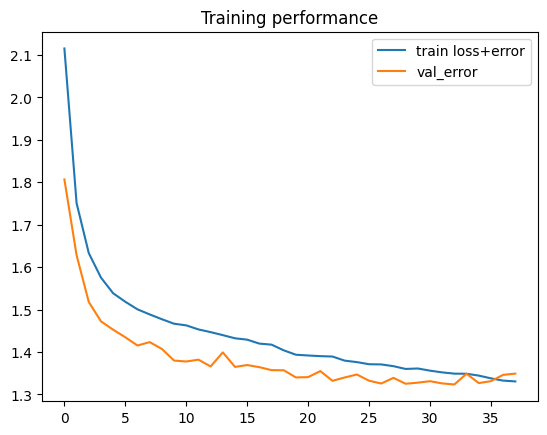

In [14]:
    # Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
# plt.figure(figsize=(8, 5))
# plt.title('Training Performance')
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [21]:
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')  # no warning now

    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_aspect(20)

    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


430/430 [==============================] - 5s 11ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


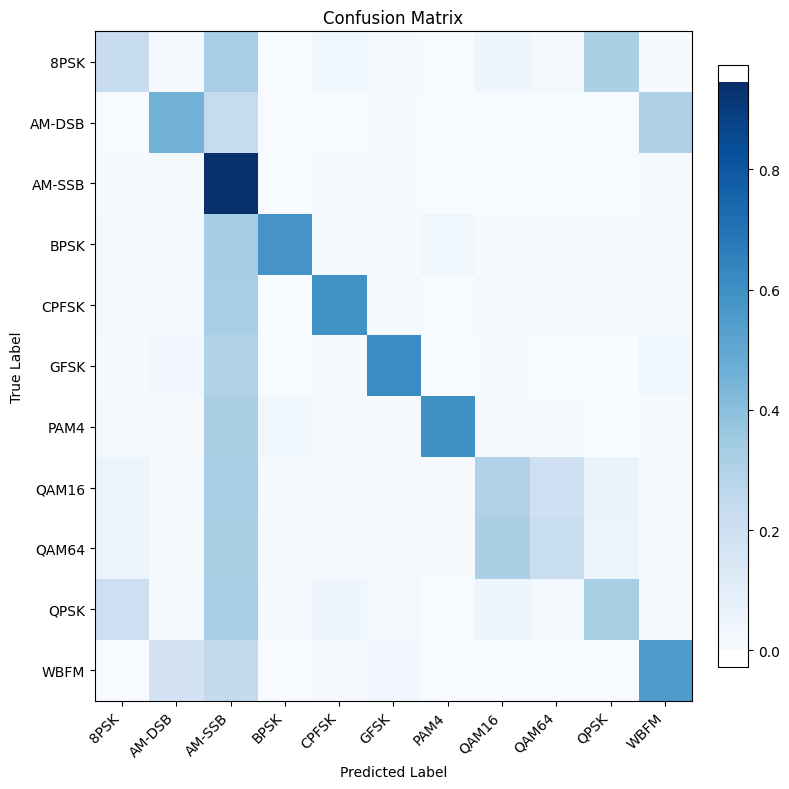

In [22]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



171/171 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

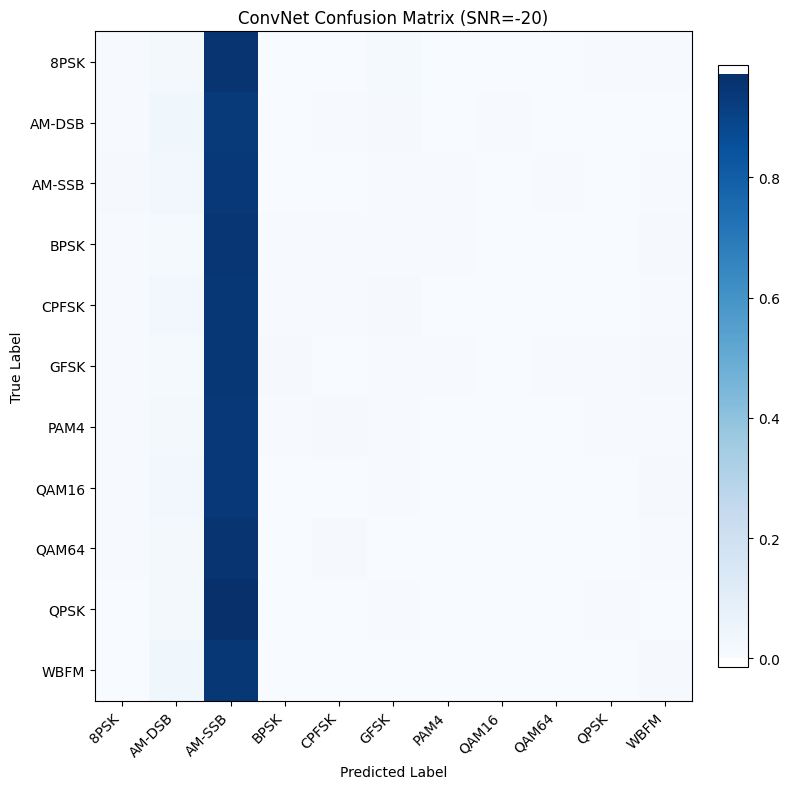

Overall Accuracy:  0.09423604757548033
173/173 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

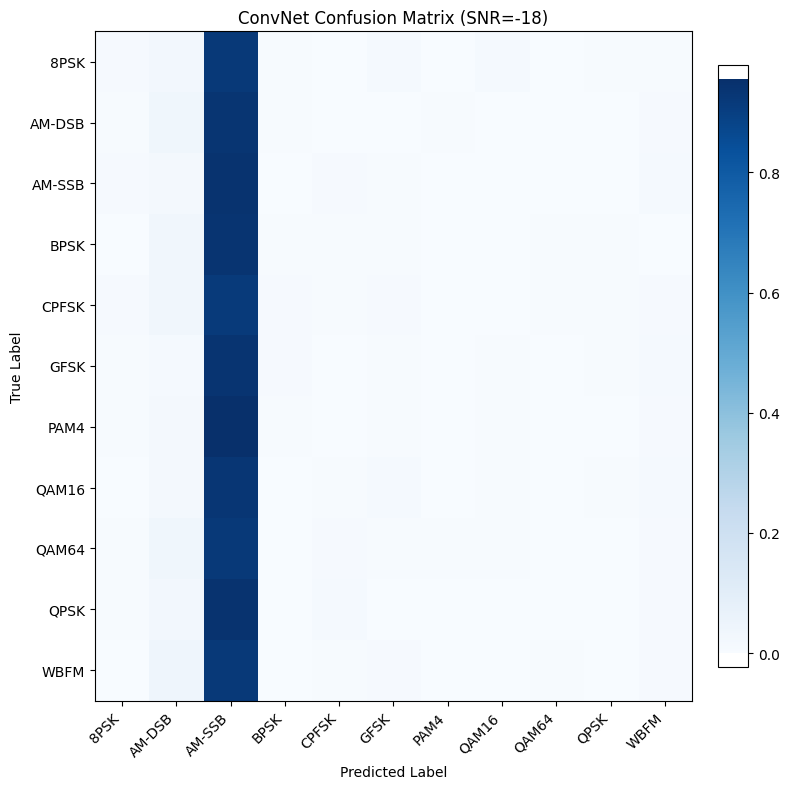

Overall Accuracy:  0.0930063578564941
173/173 [==============================] - 1s 3ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

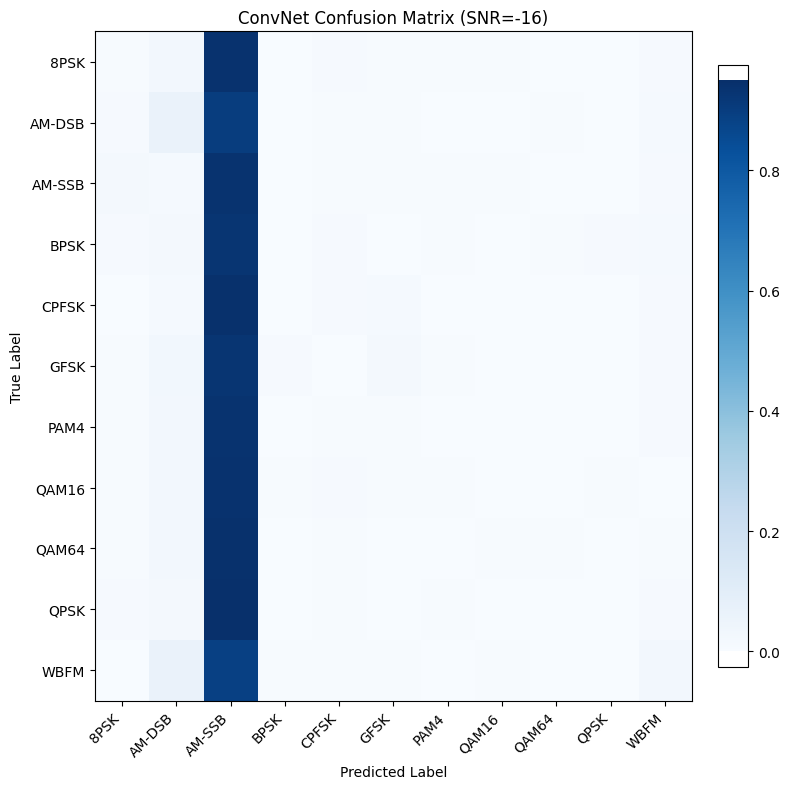

Overall Accuracy:  0.09641823444283647
174/174 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

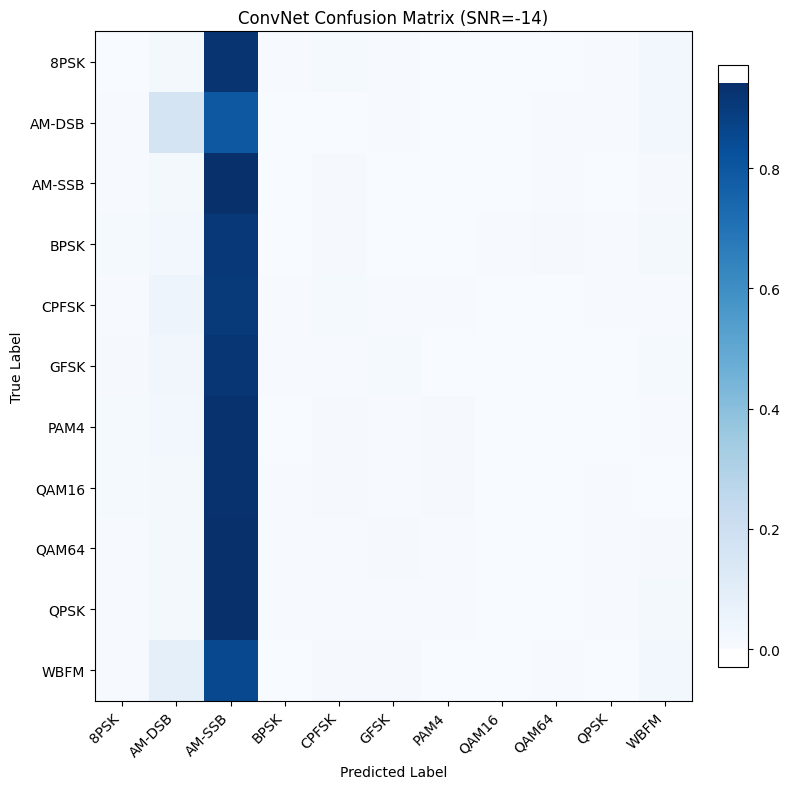

Overall Accuracy:  0.10447491880187658
172/172 [==============================] - 1s 6ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

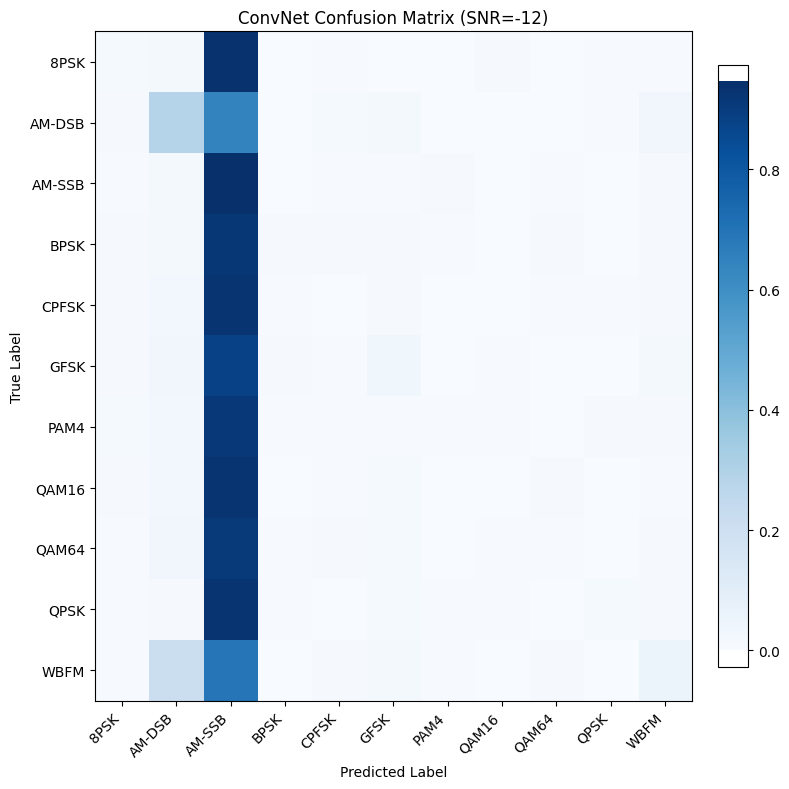

Overall Accuracy:  0.1283500455788514
176/176 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

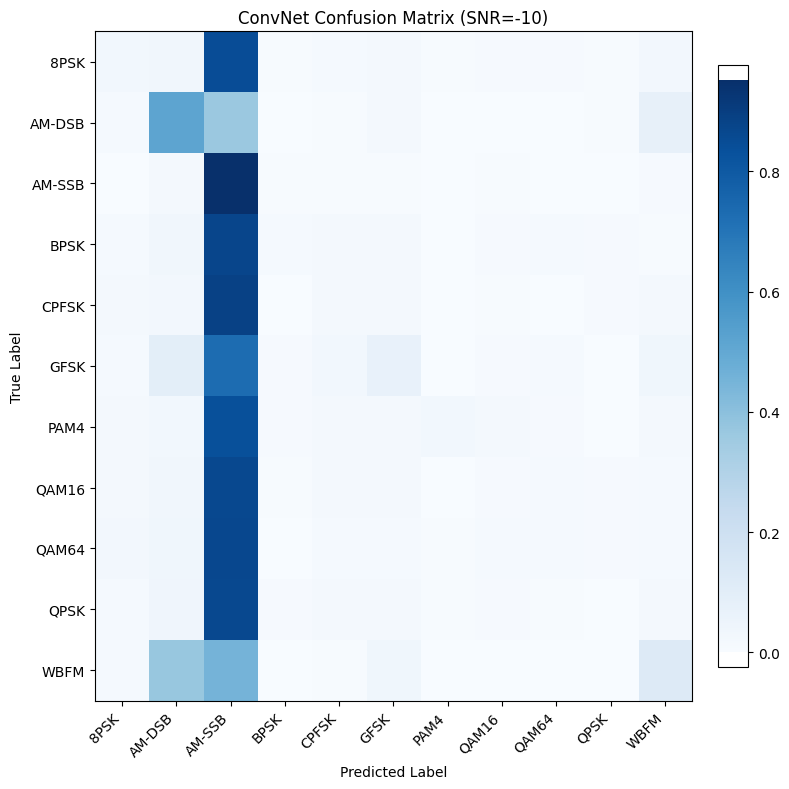

Overall Accuracy:  0.15887684378887507
171/171 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

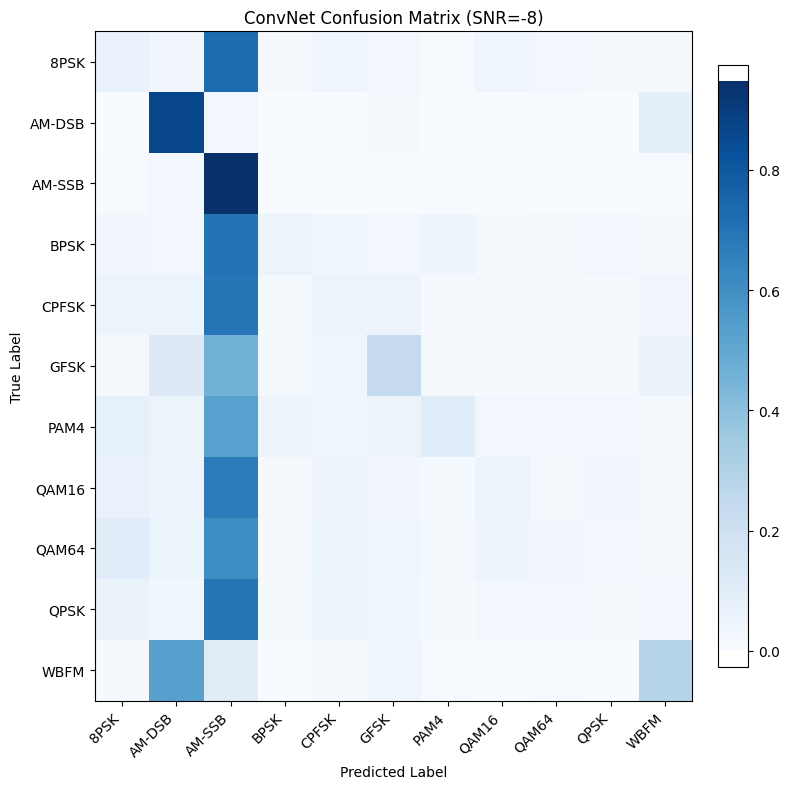

Overall Accuracy:  0.24030865331618592
171/171 [==============================] - 1s 3ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

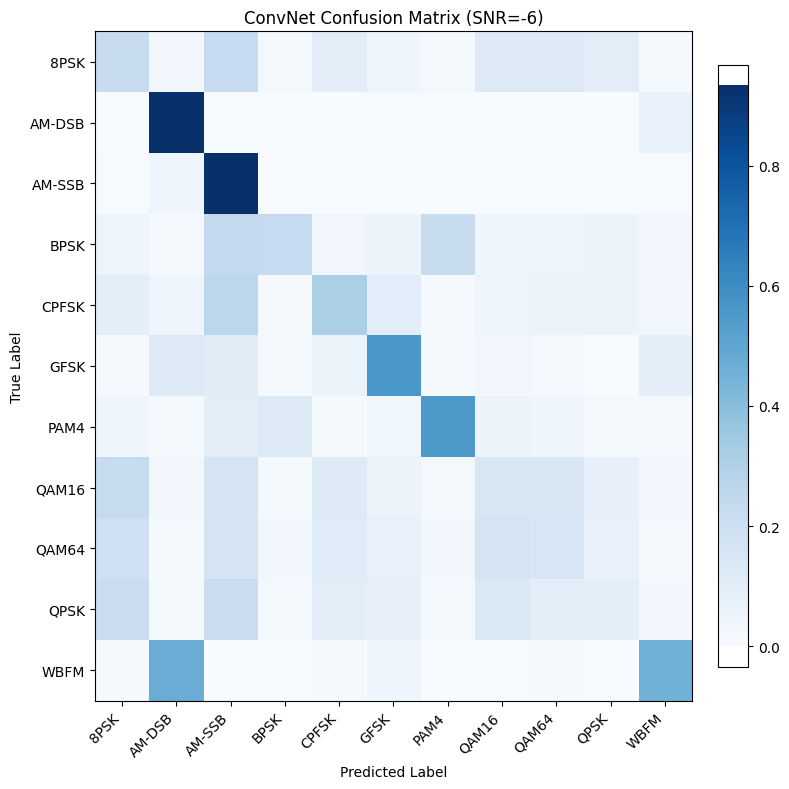

Overall Accuracy:  0.4120234604105572
170/170 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

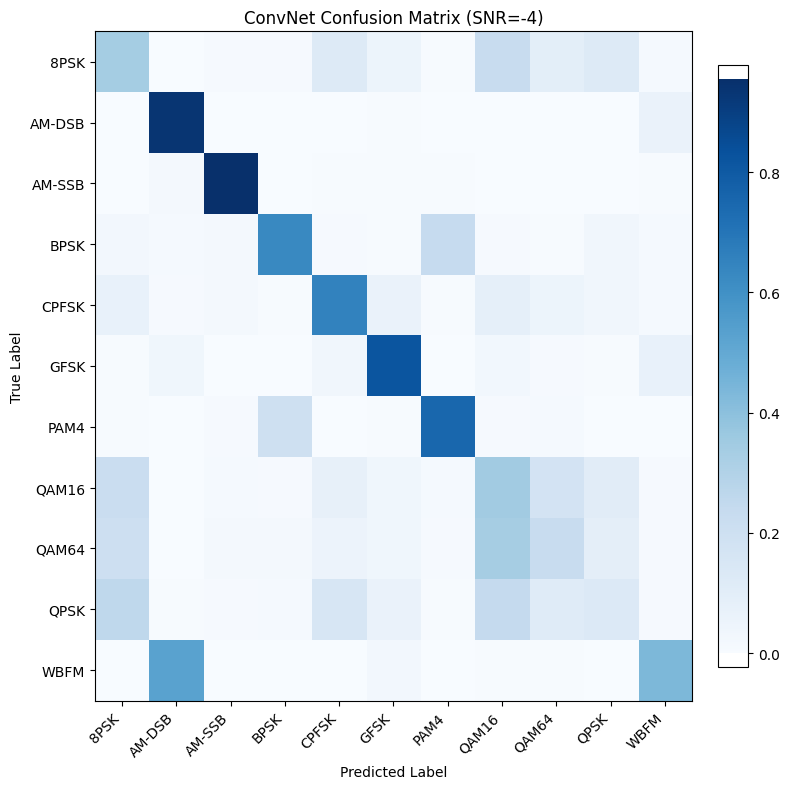

Overall Accuracy:  0.5646950092421442
173/173 [==============================] - 1s 4ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

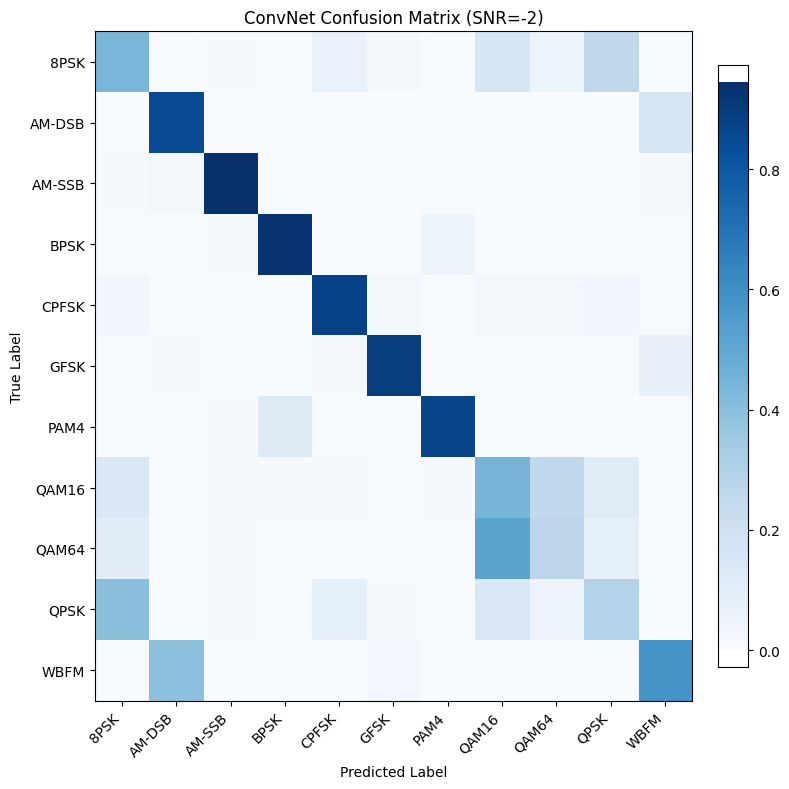

Overall Accuracy:  0.6650943396226415
172/172 [==============================] - 1s 3ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

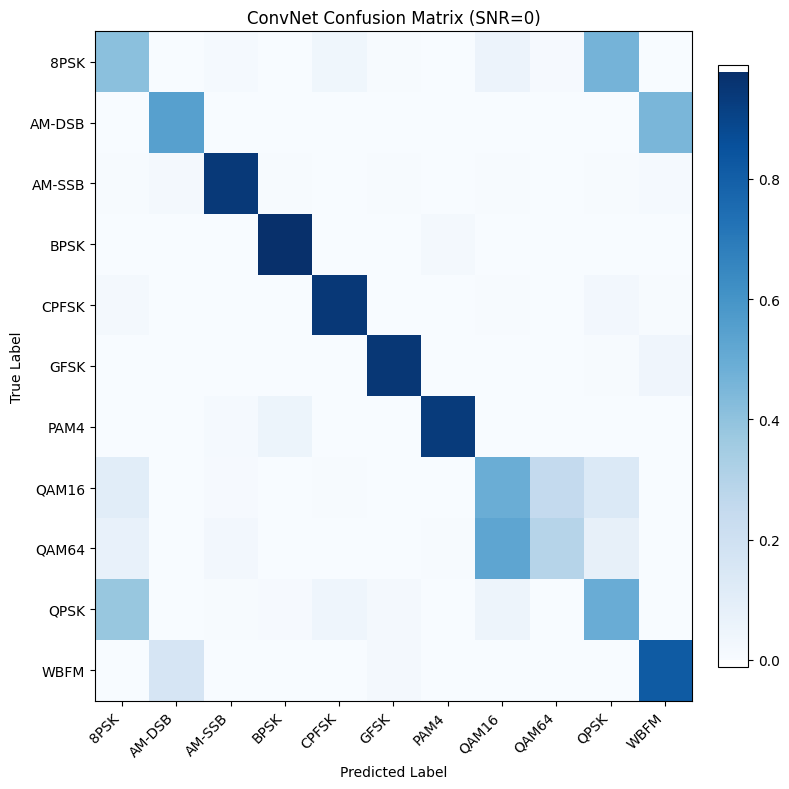

Overall Accuracy:  0.7074817518248175
172/172 [==============================] - 1s 3ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<Figure size 640x480 with 0 Axes>

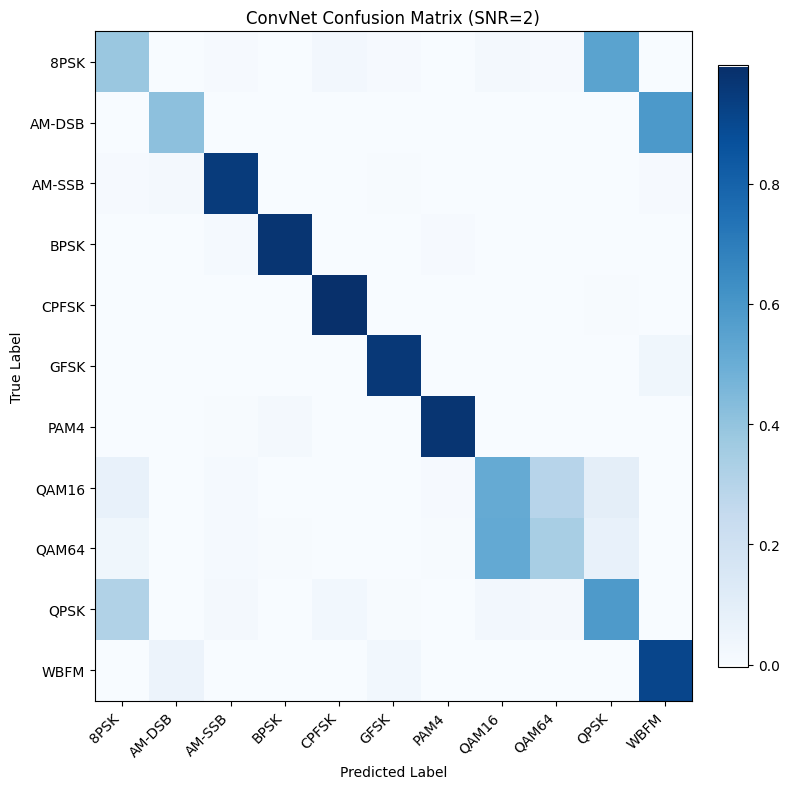

Overall Accuracy:  0.7239185750636132
171/171 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

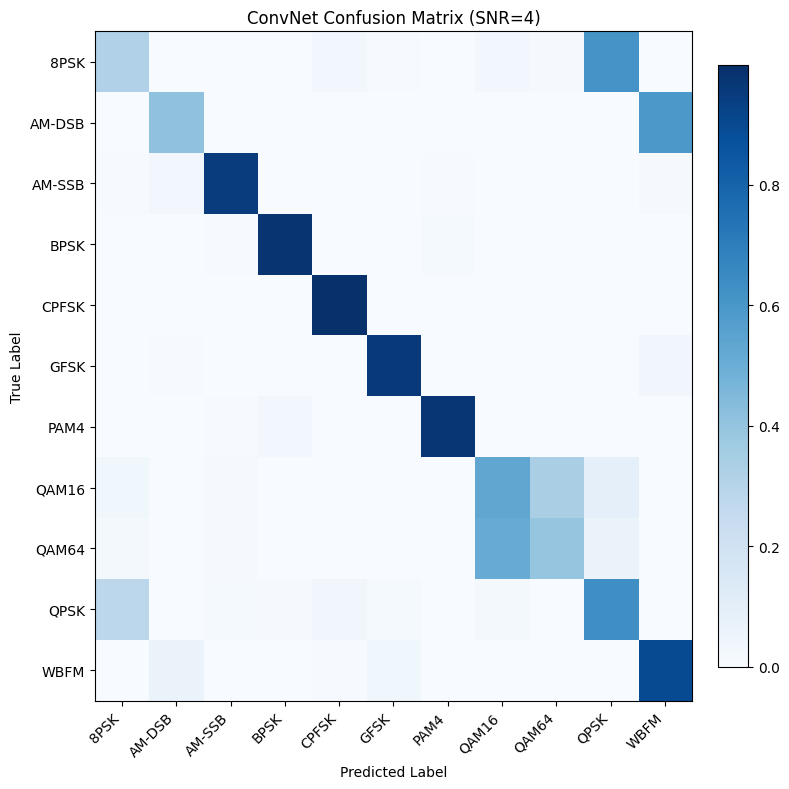

Overall Accuracy:  0.729992657856094
174/174 [==============================] - 1s 4ms/step


<Figure size 640x480 with 0 Axes>

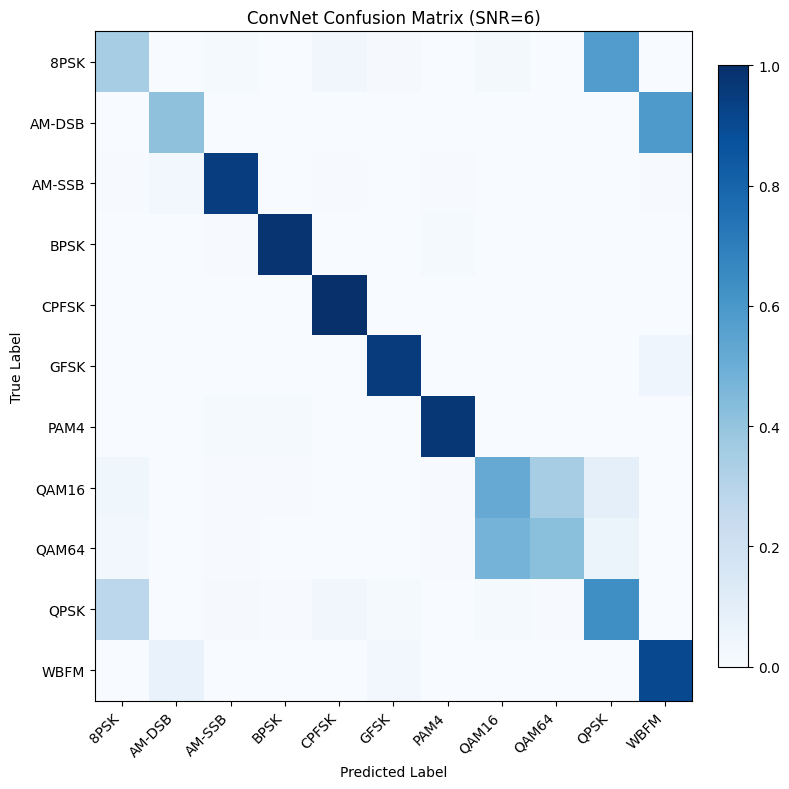

Overall Accuracy:  0.7348375451263538
174/174 [==============================] - 1s 4ms/step


<Figure size 640x480 with 0 Axes>

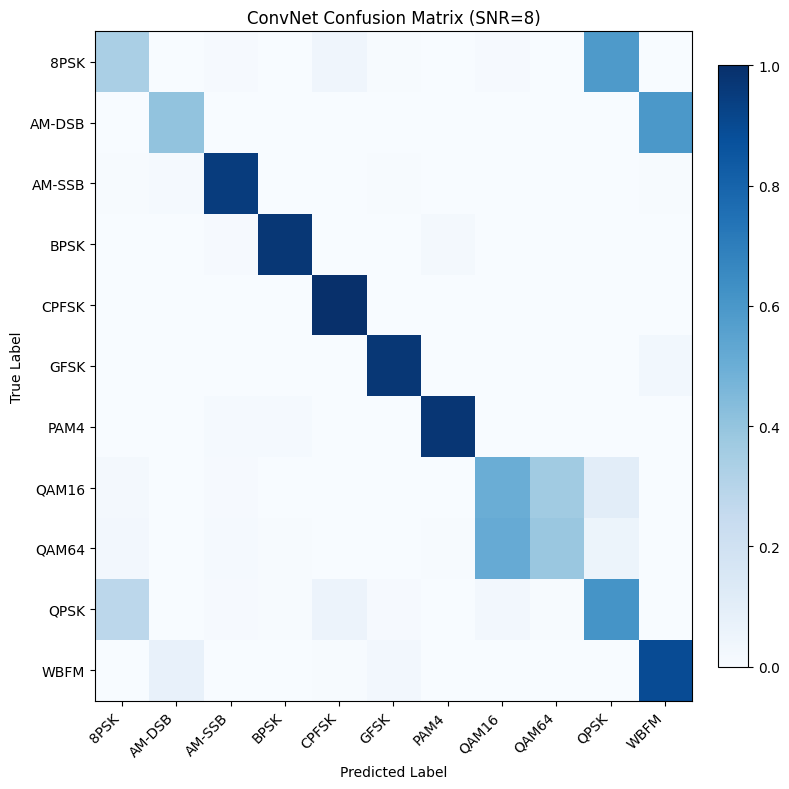

Overall Accuracy:  0.7266005410279531
172/172 [==============================] - 1s 4ms/step


<Figure size 640x480 with 0 Axes>

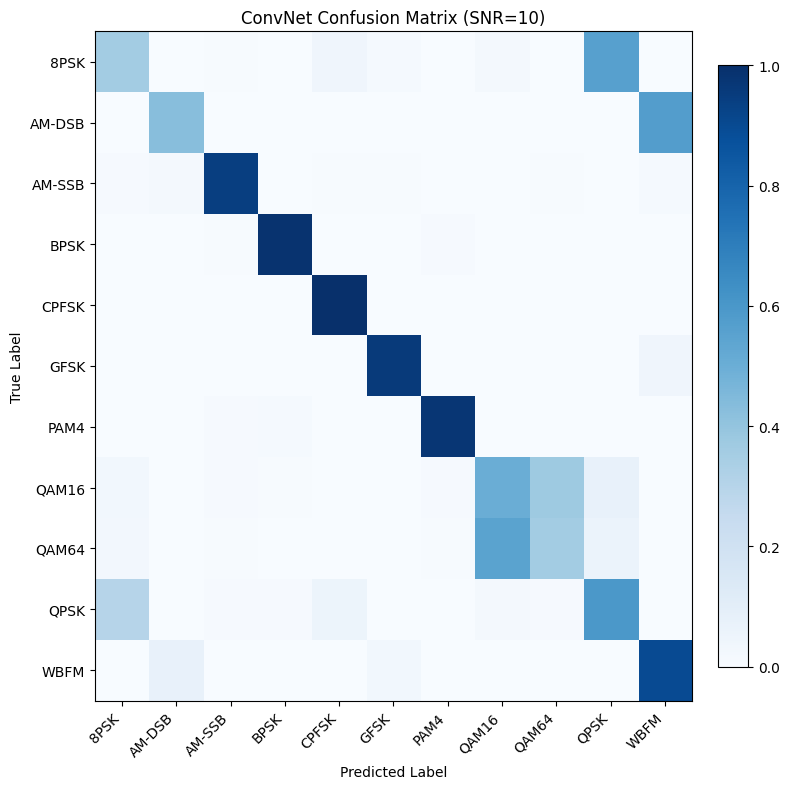

Overall Accuracy:  0.7280510018214936
173/173 [==============================] - 1s 4ms/step


<Figure size 640x480 with 0 Axes>

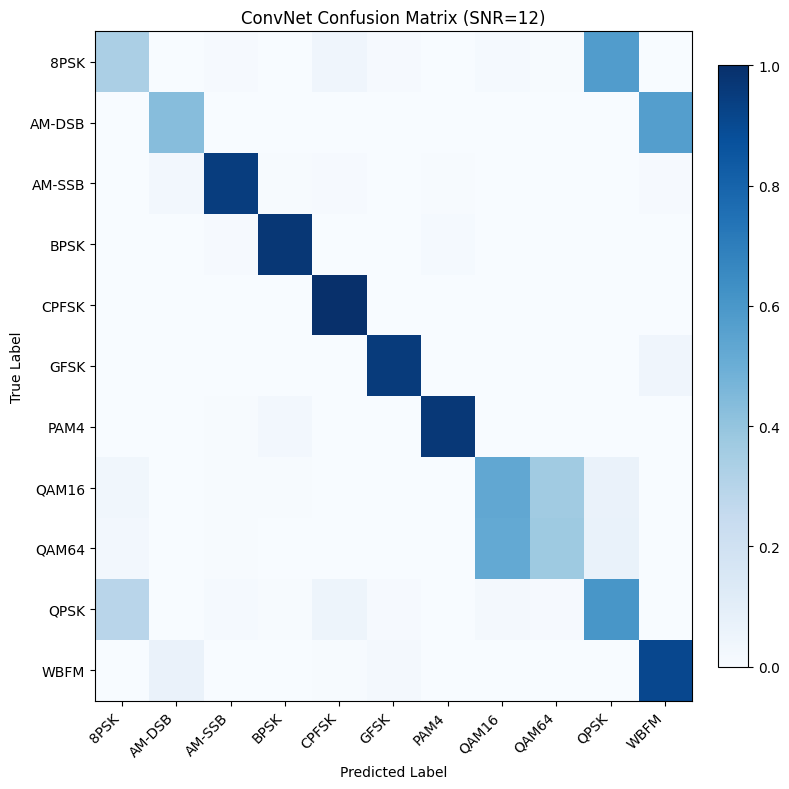

Overall Accuracy:  0.7313054499366286
170/170 [==============================] - 1s 4ms/step


<Figure size 640x480 with 0 Axes>

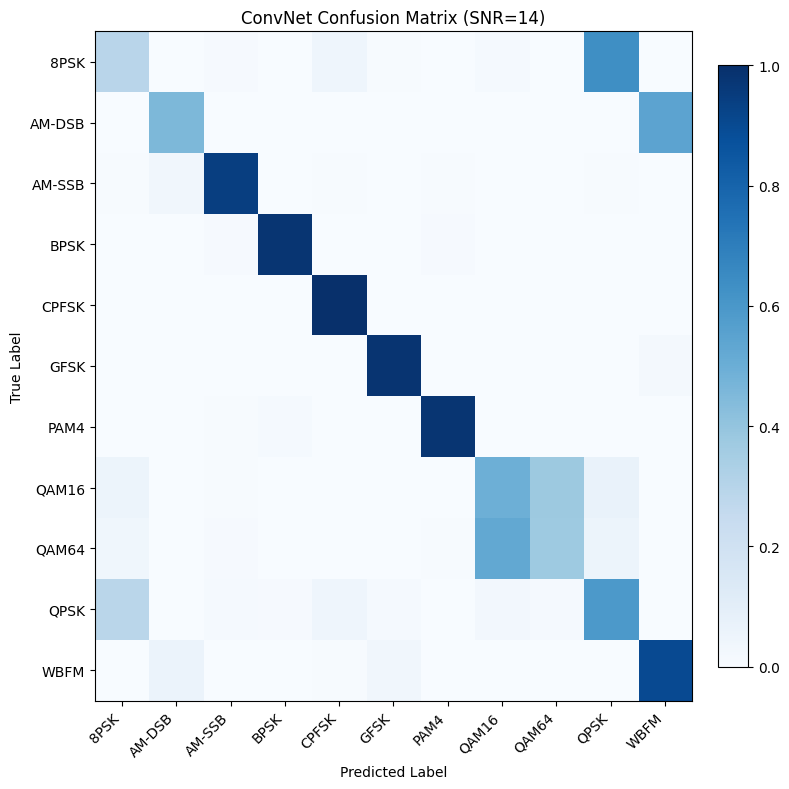

Overall Accuracy:  0.7279940948514486
173/173 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

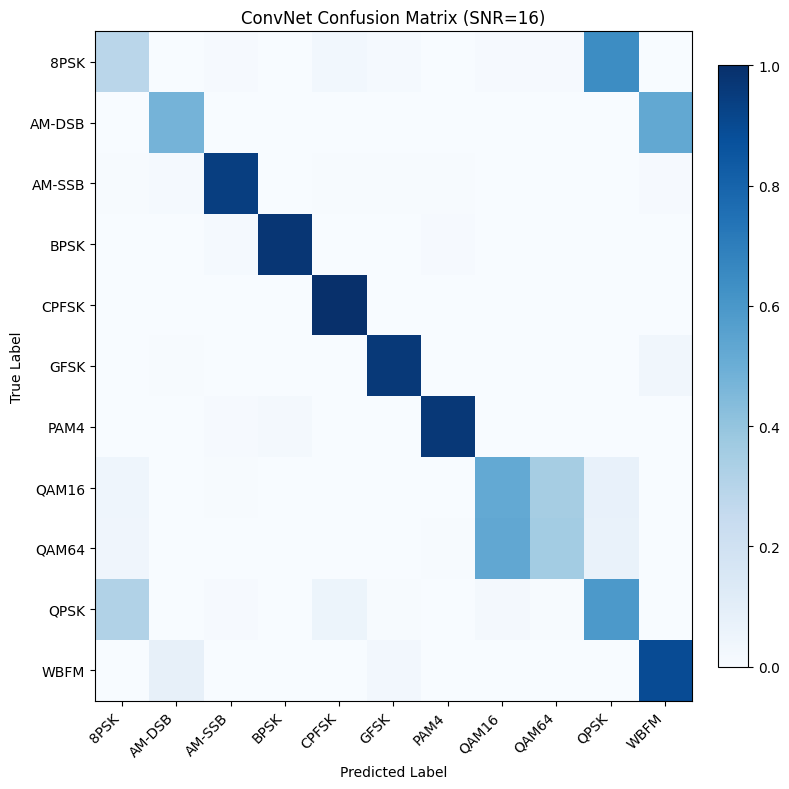

Overall Accuracy:  0.7250678733031675
174/174 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

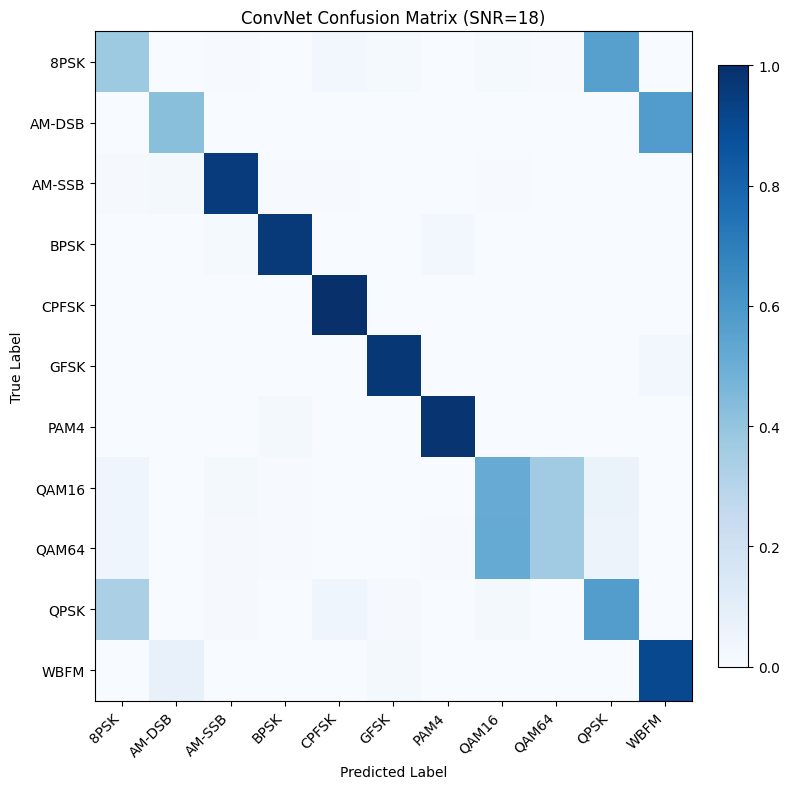

Overall Accuracy:  0.7267326732673267


In [23]:
# # Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))  # <-- convert map to list
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)[0]]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)[0]]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)
    

In [24]:
# Save results to a pickle file for plotting later
print (acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.09423604757548033, -18: 0.0930063578564941, -16: 0.09641823444283647, -14: 0.10447491880187658, -12: 0.1283500455788514, -10: 0.15887684378887507, -8: 0.24030865331618592, -6: 0.4120234604105572, -4: 0.5646950092421442, -2: 0.6650943396226415, 0: 0.7074817518248175, 2: 0.7239185750636132, 4: 0.729992657856094, 6: 0.7348375451263538, 8: 0.7266005410279531, 10: 0.7280510018214936, 12: 0.7313054499366286, 14: 0.7279940948514486, 16: 0.7250678733031675, 18: 0.7267326732673267}


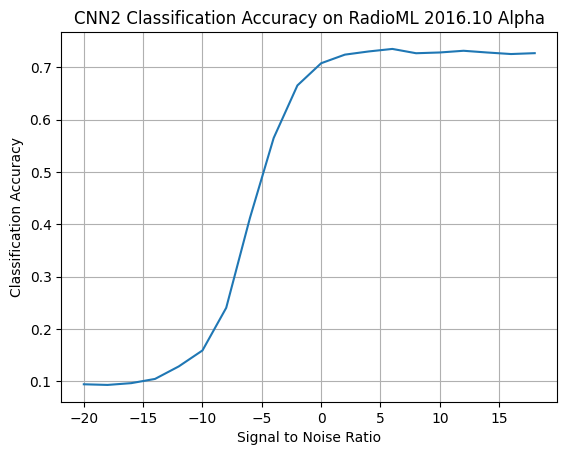

In [25]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")
plt.grid(True)
plt.show()
